# E-tivity 1 (24/01/22 - 06/02/22)

* Tom Keane

* 20214537

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv". 

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Guidelines

The e-tivity is split into four tasks. The first three are "group" excersises, in that you post the solutions to Tasks 1-3 to a site. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to Sulis but not to gitlab. 

Marks will be deducted if task 4 is posted to gitlab in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-4 and with correct identification or filename.

Grading guidelines: the scores for each task are additive, max 20. Weight [5/7]

**Task 1 [0-6]**: complete with sensible feature selection and data in suitable form for use in NN.

**Task 2 [0-4]**: suitable autoencoder model that has been correctly trained.

**Task 3 [0-4]**: correct histogram and threshold.

**Task 4 [0-6]**: implement a suitable VAE and correct testing.

## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available from the Sulis site, download the csv file and use it as the input data.

### Tasks 1-3 (complete by Monday 31/01/22)

These tasks are to be completed and uploaded to GitLab on which the other group members can comment. The forum activity will form part of the overall mark for the e-tivity.

### Post (complete by Monday 31/01/22)

Post your solution to Tasks 1-3 in notebook form. If you have not completed all the tasks then that is acceptable. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should refer to Task 4.

### Respond (complete by Wednesday 02/02/22)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

Grading guidelines for the forum posts: Weight [2/7]

**Beginning [0-8]:** Respectful posts of minor value. Significant number of posts without valuable contributions and/or without well-considered questions. Posts about task 4 in contravention of intructions.

**Developing [9-12]:** At least 1 post  exceeding Beginning level with respectful suggestion or thought provoking question. Most posts contain valuable contributions or well-considered questions.

**Advancing [13-16]:** At least 2 posts: 1 equal to or exceeding Beginning level;  1 with respectful and sound contribution highlighting mistakes or alternative approaches.

**Accomplished [17-20]:** At least 3 posts: 2 equal to or exceeding Accomplished level; 1 with respectful contribution of significant value. 

### Final Submission (complete by Sunday 06/02/22)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


# **Task 0: Setup and initial Data Exploration**

##### Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
% cd /content/
% cp -R /content/gdrive/MyDrive/UL_Masters/CS5004/ /content/
! ls  CS5004	

/content
et1


In [3]:
def display_df(df):
  display(df)
  display(df.describe())

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

import random as rn


# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 44500
VALIDATE_SIZE = 0.2


# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

df = pd.read_csv("/content/CS5004/et1/data.csv")
df_original = df.copy()


### Initial data exploration

In [5]:
df.columns = map(str.lower, df.columns)
df.columns

Index(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'anom'], dtype='object')

In [6]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    if dimensions not in (2, 3):
        raise ValueError('tsne_scatter can only plot in 2d or 3d (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)')

    # t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)
    
    # initialising the plot
    fig, ax = plt.subplots(figsize=(8,8))
    
    # counting dimensions
    if dimensions == 3: ax = fig.add_subplot(111, projection='3d')

    # plotting data
    ax.scatter(
        *zip(*features_embedded[np.where(labels==1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='anomoly'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels==0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='typical'
    )

    # storing it to be displayed later
    plt.legend(loc='best')
    plt.savefig(save_as);
    plt.show;

def initial_df_exploration(df, tsne=True, size=1500):
  display_df(df.tail())
  df = df.sample(size)

  # isolate features from labels 
  features, labels = df.drop('anom', axis=1).values, \
                    df.anom.values
  tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')


In [7]:
  # initial_df_exploration(df)

## Initial Impressions

Looks like there's no need to remove any columns as theyr'e already numerical, and lack of context means that there's no point in adding any new columns via combinations or transformations.

# **Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


non-anom : anom is about 13:1, so under/oversampling doesn't seem to be necesary.

In [8]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

def split_by_class(df):
  anom_df = df[df.anom == 1]
  nanom_df = df[df.anom == 0]
  print(f"""Shape of the datasets:
    non-anomalous (rows, cols) = {nanom_df.shape}
    anomalous     (rows, cols) = {anom_df.shape}""")
  print("non-anom : anom   =    " + str(nanom_df.anom.count()/ anom_df.anom.count())+ " : 1")
  return anom_df, nanom_df


def train_validate_test_split(anom_df, nanom_df):
  # shuffle our training set
  nanom_df = nanom_df.sample(frac=1).reset_index(drop=True)

  # training set: exlusively non-anomalous
  X_train = nanom_df.iloc[:TRAINING_SAMPLE].drop('anom', axis=1)
  # testing  set: the remaining non-anomalous + all the anomalies 
  X_test = nanom_df.iloc[TRAINING_SAMPLE:].append(anom_df).sample(frac=1)

  from sklearn.model_selection import train_test_split

  # train // validate - no labels since they're all clean anyway
  X_train, X_validate = train_test_split(X_train, 
                                        test_size=VALIDATE_SIZE, 
                                        random_state=RANDOM_SEED)

  # manually splitting the labels from the test df
  X_test, y_test = X_test.drop('anom', axis=1).values, X_test.anom.values

  print(f"""Shape of the datasets:
      training (rows, cols) = {X_train.shape}
      validate (rows, cols) = {X_validate.shape}
      holdout  (rows, cols) = {X_test.shape}""")
  return X_train, X_validate, X_test, y_test



def paireplot_dataset(X, suptitle=""):
  g = sns.PairGrid(X.iloc[:,:3].sample(600, random_state=RANDOM_SEED))
  plt.subplots_adjust(top=0.9)
  g.fig.suptitle(suptitle)
  g.map_diag(sns.kdeplot)
  g.map_offdiag(sns.kdeplot)

def visualise_transform(X, X_transformed):
  paireplot_dataset(X, suptitle="BEFORE")
  paireplot_dataset(X_transformed, suptitle="AFTER")


In [9]:
def data_preprocessing(df):
  anom_df, nanom_df = split_by_class(df)

  # configure our pipeline
  pipeline = Pipeline([('RobustScaler', RobustScaler()),
                      ('MinMaxScaler', MinMaxScaler())])

  # get vanilla datasets
  X_train, X_validate, X_test, y_test = train_validate_test_split(anom_df, nanom_df)


  # get normalization parameters by fitting to the training data
  pipeline.fit(X_train);
  # transform datasets
  X_train_transformed      = pipeline.transform(X_train)
  X_validate_transformed   = pipeline.transform(X_validate)
  X_test_transformed       = pipeline.transform(X_test)
  visualise_transform(X_train, pd.DataFrame(X_train_transformed))
  return X_train_transformed, X_validate_transformed, X_test_transformed, y_test  

Shape of the datasets:
    non-anomalous (rows, cols) = (45586, 10)
    anomalous     (rows, cols) = (3511, 10)
non-anom : anom   =    12.983765309028767 : 1
Shape of the datasets:
      training (rows, cols) = (35600, 9)
      validate (rows, cols) = (8900, 9)
      holdout  (rows, cols) = (4597, 9)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  "X does not have valid feature names, but"


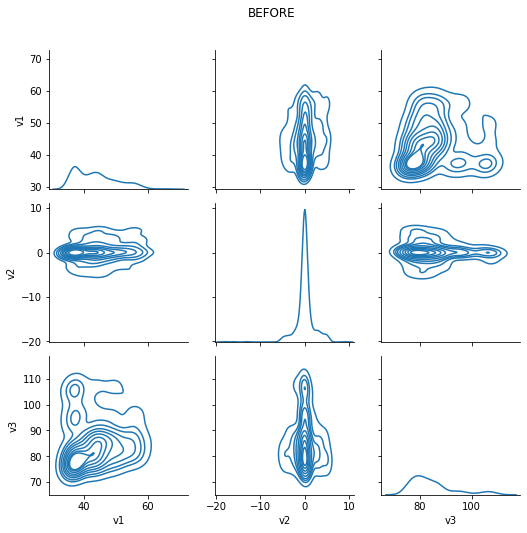

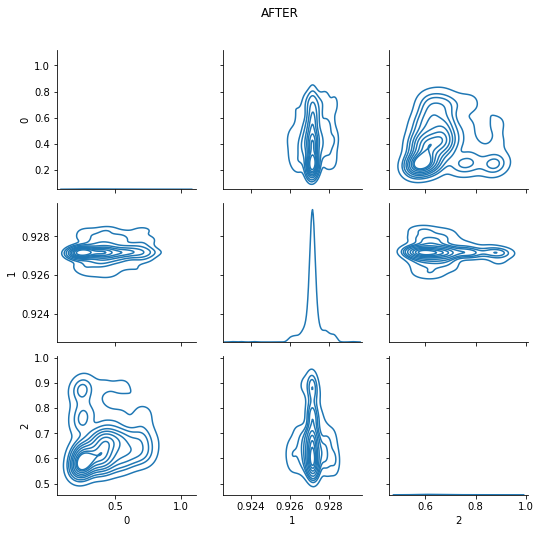

In [10]:
X_train_transformed, X_validate_transformed, X_test_transformed, y_test =  data_preprocessing(df)

There doesn't appear to be too much of an effect made by the pipeline transformations.

# **Task 2: model generation and training**

Generate a suitable autoencoder model, the only restriction is that there should be only 2 latent variables. Train the model to a satistifactory result. Be aware that it will be much harder to achieve the sort of result you can get from a supervised learning model. 

**Hint**: it should not take longer than a 1000 epochs to train. However it may be difficult to train. Use different optimizers, topologies and/or weight initialisations to get convergence. Remember that achieving a perfect error means that the model will also be good at reconstructing anomalies. 


### Training the auto-encoder

In [12]:
# Load the extension and start TensorBoard

# %load_ext tensorboard.notebook
# %tensorboard --logdir logs

In [13]:
# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 256
EPOCHS = 100
print(f"input dim  :  {input_dim}")

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='linear', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(4,         activation='linear'),
    tf.keras.layers.Dense(2,         activation='linear'), # latent vars
    
    # reconstruction / decode
    tf.keras.layers.Dense(4,         activation='linear'),
    tf.keras.layers.Dense(input_dim, activation='linear')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

# print an overview of our model
autoencoder.summary();

input dim  :  9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 4)                 40        
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
 dense_4 (Dense)             (None, 9)                 45        
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


#### callbacks

In [14]:
from datetime import datetime

def define_callbacks():
  # current date and time
  yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

  # new folder for a new run
  log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

  # define our early stopping
  early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.0001,
      patience=10,
      verbose=1, 
      mode='min',
      restore_best_weights=True
  )

  save_model = tf.keras.callbacks.ModelCheckpoint(
      filepath='autoencoder_best_weights.hdf5',
      save_best_only=True,
      monitor='val_loss',
      verbose=0,
      mode='min'
  )

  tensorboard = tf.keras.callbacks.TensorBoard(
      f'logs/{log_subdir}',
      batch_size=BATCH_SIZE,
      update_freq='batch'
  )

# callbacks argument only takes a list
  return early_stop, save_model, tensorboard

cb = define_callbacks()

#### training

In [15]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Epoch 1/100
140/140 [==============================] - 3s 9ms/step - loss: 0.0889 - acc: 0.6045 - val_loss: 0.0066 - val_acc: 0.9545
Epoch 2/100
140/140 [==============================] - 1s 5ms/step - loss: 0.0051 - acc: 0.9562 - val_loss: 0.0050 - val_acc: 0.9545
Epoch 3/100
140/140 [==============================] - 1s 6ms/step - loss: 0.0049 - acc: 0.9562 - val_loss: 0.0049 - val_acc: 0.9545
Epoch 4/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0048 - acc: 0.9562 - val_loss: 0.0048 - val_acc: 0.9545
Epoch 5/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0047 - acc: 0.9562 - val_loss: 0.0048 - val_acc: 0.9545
Epoch 6/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0047 - acc: 0.9562 - val_loss: 0.0047 - val_acc: 0.9545
Epoch 7/100
140/140 [==============================] - 0s 2ms/step - loss: 0.0046 - acc: 0.9562 - val_loss: 0.0047 - val_acc: 0.9545
Epoch 8/100
140/140 [==============================] - 0s 3ms/step - 

# **Task 3: anomaly detection**

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%.

In [16]:
# pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

In [17]:
def set_ylim_from_hist_bin_heights(y0, y1):
  y0 = y0.max()
  y1 = y1.max()
  highest=y0 if y0 > y1 else y1
  print(f"MAX BIN HEIGHT =  {highest}")
  ylim = y0 if y0 < y1 else y1
  return ylim*1.3

def plot_loss_dist(anom_df, nanom_df, bins=300, xlim=None, xlabel="", title=""):
  fig, ax = plt.subplots(figsize=(6,6))
  y0, x, _ = ax.hist(nanom_df, bins=bins, density=True, label="typical", alpha=.6, color="green")
  y1, x, _ = ax.hist(anom_df,  bins=bins, density=True, label="anomaly", alpha=.6, color="red")
  ax.set_xlabel(xlabel)
  ax.set_ylim((0,set_ylim_from_hist_bin_heights(y0, y1)))
  if xlim is not None:
    ax.set_xlim(xlim)
  plt.title(title)
  plt.legend()
  plt.show()



def reconstructed_loss_analysis(mse, y_test, zooms=[0.057, 0.01, 0.0018]):
  nanom_df = mse[y_test==0]
  anom_df   = mse[y_test==1]
  title = "(Normalized) Distribution of the Reconstruction Loss"


  plot_loss_dist(anom_df, nanom_df, bins=300, xlim=None,
                 xlabel="Loss", title=title)
  for z in zooms:
    print("ZOOM IN")
    plot_loss_dist(anom_df, nanom_df, bins=300, xlim=(0,z),
                  xlabel="Loss", title=title)


def mad_score(points):
  # median absolute deviations
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

def modified_z_score_analysis(mse, THRESHOLD=0.001, show=False, xlim=(0,1.5)):
  z_scores = mad_score(mse)
  outliers = z_scores > THRESHOLD

  print(f"Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

  nanom_df = z_scores[y_test==0]
  anom_df = z_scores[y_test==1]
  if show:
    plot_loss_dist(anom_df, nanom_df, bins=500, xlim=xlim, xlabel="z-score")

  # get (mis)classification
  cm = confusion_matrix(y_test, outliers)

  # true/false positives/negatives
  (tn, fp, 
  fn, tp) = cm.flatten()


  print(f"""The classifications using the MAD method with threshold={THRESHOLD} are as follows:
  |tn, fp,| 
  |fn, tp  |
  {cm}
  $--------------------------------
  % of values labeled as anomaly that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
  % of anomalies were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}
  %--------------------------------""")


MAX BIN HEIGHT =  17389.741971270312


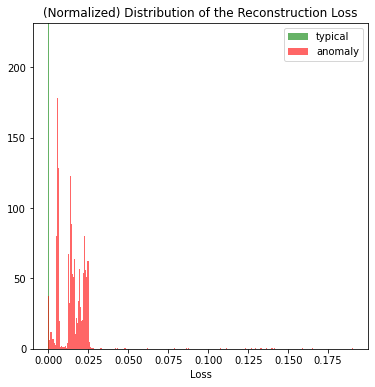

ZOOM IN
MAX BIN HEIGHT =  17389.741971270312


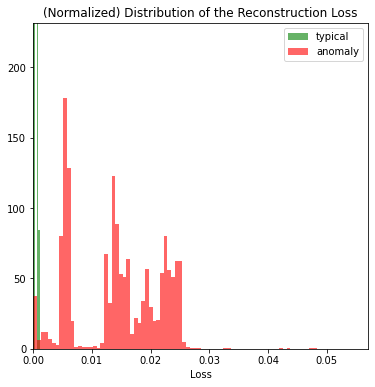

ZOOM IN
MAX BIN HEIGHT =  17389.741971270312


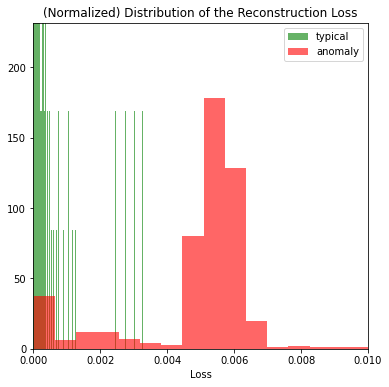

ZOOM IN
MAX BIN HEIGHT =  17389.741971270312


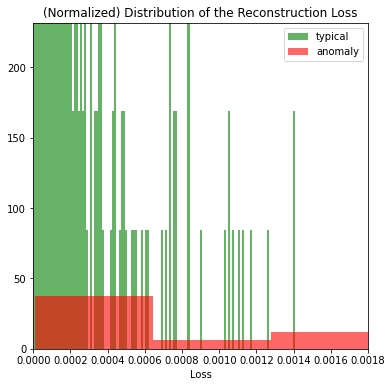

In [18]:
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
reconstructed_loss_analysis(mse, y_test)

Threshold =  0.0003
Detected 4,538 outliers in a total of 4,597 transactions [98.72%].
MAX BIN HEIGHT =  222.2710970783552


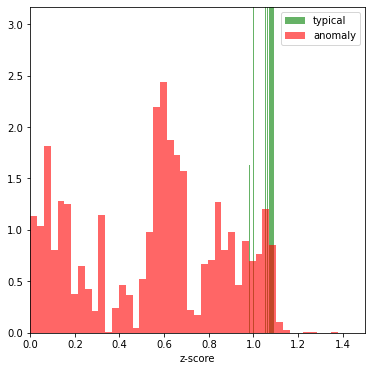

The classifications using the MAD method with threshold=0.0003 are as follows:
  |tn, fp,| 
  |fn, tp  |
  [[   0 1086]
 [  59 3452]]
  $--------------------------------
  % of values labeled as anomaly that were correct (precision): 3452/(1086+3452) = 76.07%
  % of anomalies were caught succesfully (recall):    3452/(59+3452) = 98.32%
  %--------------------------------
Threshold =  0.0009
Detected 4,538 outliers in a total of 4,597 transactions [98.72%].
The classifications using the MAD method with threshold=0.0009 are as follows:
  |tn, fp,| 
  |fn, tp  |
  [[   0 1086]
 [  59 3452]]
  $--------------------------------
  % of values labeled as anomaly that were correct (precision): 3452/(1086+3452) = 76.07%
  % of anomalies were caught succesfully (recall):    3452/(59+3452) = 98.32%
  %--------------------------------
Threshold =  0.0027
Detected 4,538 outliers in a total of 4,597 transactions [98.72%].
The classifications using the MAD method with threshold=0.0027 are as follows:

In [19]:
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

THRESHOLD = 0.0001
for t in range(3):
  THRESHOLD = np.round(THRESHOLD+THRESHOLD*2, 4)
  print(f"Threshold =  {THRESHOLD}")
  modified_z_score_analysis(mse, THRESHOLD, show=(t==0))

This looks good. There's a clear separation im loss between the typical set and the anomalies.

**mse = 0.0012** looks like a reasonable first guess at a threshold for this dataset

In [20]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 4)                 40        
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 dense_3 (Dense)             (None, 4)                 12        
                                                                 
 dense_4 (Dense)             (None, 9)                 45        
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [37]:
def create_latent_space_representations(x, y, encoder):
  # taking all the fraud, undersampling clean
  anom_df = x[y==1]
  nanom_df = x[y==0]

  # combining arrays & building labels
  features = np.append(anom_df, nanom_df, axis=0)
  labels = np.append(np.ones(len(anom_df)),
                    np.zeros(len(nanom_df)))

  # getting latent space representation
  latent_representation = encoder.predict(features)

  print('Shape of latent representation:', latent_representation.shape)
  return latent_representation, labels

def plot_latent_space(latent_representation, labels):
  X = latent_representation[:,0]
  y = latent_representation[:,1]
  print(X)
  print(y)
  xmin, xmax, ymin, ymax = np.min(X), np.max(X), np.min(y), np.max(y)
  xborder, yborder = (xmax - xmin)*0.05, (ymax - ymin)*0.05

  # plotting
  plt.subplots(figsize=(8, 8))
  plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.2, label='typical')
  plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.2, label='anomaly')
  plt.xlim(xmin-xborder, xmax+xborder)
  plt.ylim(ymin-yborder, ymax+yborder)
  # labeling
  plt.legend(loc='best')
  plt.title('Latent Space Representation')

  # saving & displaying
  plt.savefig('latent_representation_2d');
  plt.show()

Shape of latent representation: (4597, 9)
[1.7996347  0.53007746 1.1453315  ... 0.2506686  0.3444512  0.53648853]
[0.94410384 0.91962963 0.92576826 ... 0.9216934  0.9197512  0.9261372 ]


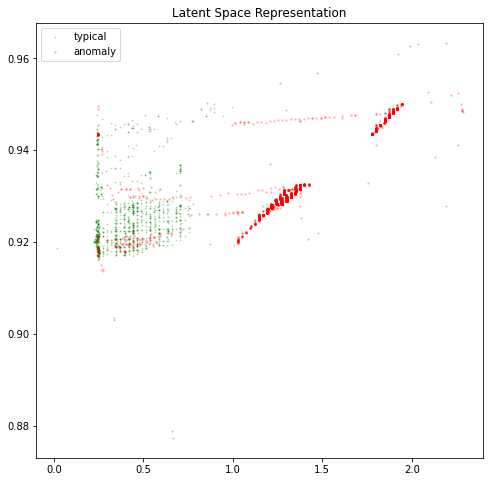

In [38]:
latent_representation, labels = create_latent_space_representations(X_test_transformed, y_test, encoder)
plot_latent_space(latent_representation, labels)

As we can see, the typical samples tend to cluster pretty closely together, whereas the anomalies have a far broader range in the latent spsce.

# **Task 4: VAE (completed by Sunday 06/02/22)**

This task is a individual task and should **not** to be uploaded to GitHub. No direct support should be given via the forums, although comments about progress or results are allowed. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Sulis.

Change the network to be a VAE. Again determine the optimal cutoff and plot the latent variables. Check how good the cutoffs were by constructing a confusion matrix or generating a classification report. Obviously for this task you need to use the Anom column.

**Hint** you can use the model topology from the AE (with the obvious modifications). I found that I had a good model (almost as good and the supervised learning model) when the KL divergence was small. You can print out both the KL divergence and reconstruction loss for each epoch. It can be tricky to train these type of models, so do not be surprised if you do not get a stellar result. What is more important is that you have the correct code to implement the VAE.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics

In [40]:
original_dim = 9
latent_dim = 6
intermediate_dim = 4
epsilon_std = 1.0

In [41]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [42]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [43]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='sigmoid')
h_decoded = decoder_h(z)

decoder_mean = Dense(original_dim)
x_decoded_mean = decoder_mean(h_decoded)

In [44]:
# instantiate VAE model
vae = Model(x, x_decoded_mean)

In [45]:
# Compute VAE loss
xent_loss = original_dim * metrics.mean_squared_error(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

In [46]:
vae.add_loss(vae_loss)

from tensorflow.keras.optimizers import RMSprop
vae.compile(optimizer=RMSprop(lr=0.1))
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 4)            40          ['input_2[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 6)            30          ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 6)            30          ['dense_10[0][0]']               
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',basey=10)
    plt.show()
    

Epoch 1/100
140/140 [==============================] - 3s 9ms/step - loss: 0.2137 - val_loss: 0.1105
Epoch 2/100
140/140 [==============================] - 1s 8ms/step - loss: 0.0828 - val_loss: 0.0756
Epoch 3/100
140/140 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0826
Epoch 4/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0856
Epoch 5/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0805 - val_loss: 0.0826
Epoch 6/100
140/140 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0885
Epoch 7/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0807 - val_loss: 0.0939
Epoch 8/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0806 - val_loss: 0.0928
Epoch 9/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.0844
Epoch 10/100
140/140 [==============================] - 0s 3ms/step - loss: 0.0806 - val_lo

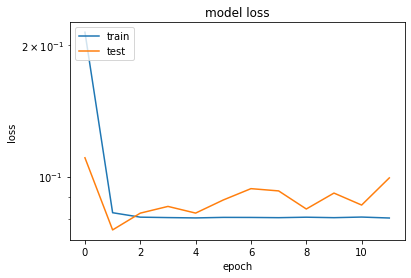

In [48]:
history = vae.fit(X_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_validate_transformed, None))

plot_loss(history)

In [49]:
print(np.shape(X_train_transformed), np.shape(X_validate_transformed), type(X_validate_transformed))

(35600, 9) (8900, 9) <class 'numpy.ndarray'>


MAX BIN HEIGHT =  360.34922157743335


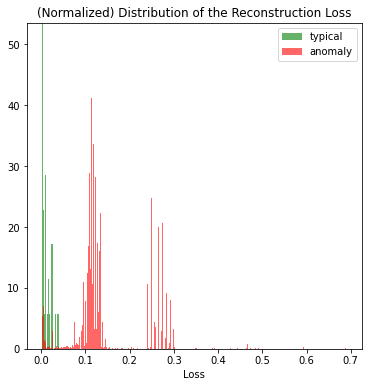

ZOOM IN
MAX BIN HEIGHT =  360.34922157743335


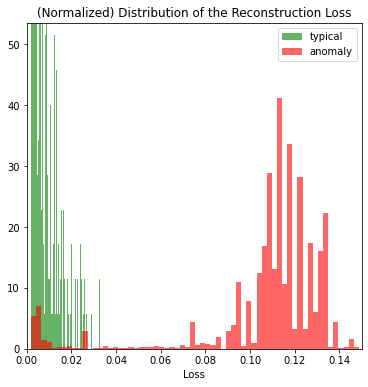

In [50]:
reconstructions = vae.predict(X_test_transformed)

mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
reconstructed_loss_analysis(mse, y_test, zooms=[0.15])

Shape of latent representation: (4597, 9)
[0.40569067 0.40468162 0.40464592 ... 0.4050985  0.4048546  0.4050273 ]
[0.9769394 0.9770921 0.9771108 ... 0.9769988 0.9770332 0.9770106]


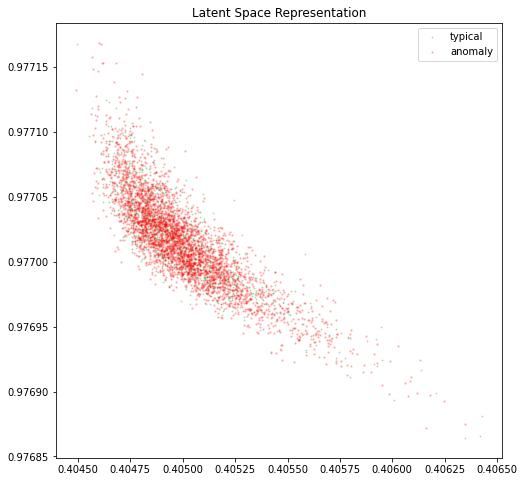

In [51]:

latent_representation, labels = create_latent_space_representations(X_test_transformed, y_test, vae)
plot_latent_space(latent_representation, labels)

It's a bit harder to make sense of this latent space. There doesn't appear to be any recogniseable traits to the classifications based on this projection, however the model performs pretty well, based on it's precision and recall (below) for a threshold of 0.02

  $--------------------------------
  % of values labeled as anomaly that were correct (precision): 3510/(1086+3510) = 76.37%
  % of anomalies were caught succesfully (recall):    3510/(1+3510) = 99.97%
  %--------------------------------

Threshold =  0.02
Detected 4,596 outliers in a total of 4,597 transactions [99.98%].
MAX BIN HEIGHT =  15.56907389756262


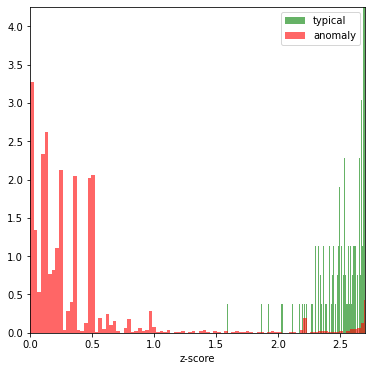

The classifications using the MAD method with threshold=0 are as follows:
  |tn, fp,| 
  |fn, tp  |
  [[   0 1086]
 [   1 3510]]
  $--------------------------------
  % of values labeled as anomaly that were correct (precision): 3510/(1086+3510) = 76.37%
  % of anomalies were caught succesfully (recall):    3510/(1+3510) = 99.97%
  %--------------------------------
Threshold =  1.02
Detected 2,210 outliers in a total of 4,597 transactions [48.07%].
The classifications using the MAD method with threshold=1 are as follows:
  |tn, fp,| 
  |fn, tp  |
  [[   0 1086]
 [2387 1124]]
  $--------------------------------
  % of values labeled as anomaly that were correct (precision): 1124/(1086+1124) = 50.86%
  % of anomalies were caught succesfully (recall):    1124/(2387+1124) = 32.01%
  %--------------------------------
Threshold =  2.02
Detected 2,152 outliers in a total of 4,597 transactions [46.81%].
The classifications using the MAD method with threshold=2 are as follows:
  |tn, fp,| 
  |f

In [52]:
THRESHOLD = 0.02
for t in range(3):
  th = np.round(t+THRESHOLD, 4)
  print(f"Threshold =  {th}")
  modified_z_score_analysis(mse, t, show=(t==0), xlim=(0, 2.7))

Looks like the VAE has it's best reults at around **Threshold =  1.02**

with these results
```
  $--------------------------------
  % of values labeled as anomaly that were correct (precision): 3510/(1086+3510) = 76.37%
  % of anomalies were caught succesfully (recall):    3510/(1+3510) = 99.97%
  %--------------------------------

```




I would be remoiss not to mention that this kaggle notebook provided me with a lot of help with these tasks.